In [3]:
import time
import requests
from bs4 import BeautifulSoup
import csv
import re
import nltk
import matplotlib.pyplot as plt
import random
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from collections import Counter, defaultdict
from math import log
import pandas as pd


nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
sw = stopwords.words("spanish") # Lista de stopwords
ss = SnowballStemmer("spanish") # Stemmer

In [5]:
def procesar_comentarios(comentarios, remover_stopwords = True):
  """Procesa una lista de comentarios y retorna una lista de listas de palabras"""
  resultados = []

  for comentario in comentarios:
    comentario = comentario.lower() # Pasarlo a minuscula
    comentario = re.sub(r"[^a-z áéíóúñü]", "", comentario) # Elimina todo lo que no sea letras o espacios
    comentario = word_tokenize(comentario, "spanish") # Separa la oración en palabras
    if remover_stopwords: # Remueve las stopwords
      comentario = [palabra for palabra in comentario if palabra not in sw]
    comentario = [ss.stem(palabra) for palabra in comentario] # Hace stemming a las palabras
    resultados.append(comentario)

  return resultados

def guardar_comentarios(nombre_archivo, comentarios):
  """Guarda una lista de comentarios en un archivo .csv"""
  with open(nombre_archivo, "w") as f:
    writer = csv.writer(f)

    writer.writerow(["comentario"])
    for comentario in comentarios:
      writer.writerow(comentario)

def cargar_comentarios(nombre_archivo):
  with open(nombre_archivo, "r") as f:
    reader = csv.reader(f)
    next(reader)

    comentarios = []
    for r in reader:
      comentarios.append(r[0])

  return comentarios

def palabras_mas_probables(dist, N=10):
  palabras, probabilidad = zip(*Counter(dist).most_common(N))
  plt.figure(figsize=(15, 5))
  plt.bar(palabras, probabilidad)
  plt.xticks(fontsize=19)
  plt.yticks(fontsize=17)
  plt.show()

In [6]:
url1 = 'https://raw.githubusercontent.com/EderArauj/Seminario/master/Datos/reviews.csv'
url2 = 'https://raw.githubusercontent.com/EderArauj/Seminario/master/Datos/reviews2.csv'
url3 = 'https://raw.githubusercontent.com/EderArauj/Seminario/master/Datos/reviews3.csv'

df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)
df3 = pd.read_csv(url3)

In [8]:
Tema1 = []
Tema2 = []
Tema3 = []

for i in range(len(df1['review text'])):
  Tema1.append(df1['review text'][i])
for i in range(len(df2['review text'])):
  Tema2.append(df2['review text'][i])
for i in range(len(df3['review text'])):
  Tema3.append(df3['review text'][i])

In [9]:
Temas = []
Temas.append(Tema1)
Temas.append(Tema2)
Temas.append(Tema3)

In [10]:
Tema1_procesados = procesar_comentarios(Tema1, remover_stopwords=True)
Tema2_procesados = procesar_comentarios(Tema2, remover_stopwords=True)
Tema3_procesados = procesar_comentarios(Tema3, remover_stopwords=True)

In [67]:
corpus1 = [palabra for Tema1 in Tema1_procesados for palabra in Tema1]
corpus2 = [palabra for Tema2 in Tema2_procesados for palabra in Tema2]
corpus3 = [palabra for Tema3 in Tema3_procesados for palabra in Tema3]

N1 = len(Tema1_procesados) // 6
N2 = len(Tema2_procesados) // 5
N3 = len(Tema3_procesados) // 5
C1 = [palabra for Tema1 in Tema1_procesados[:N1] for palabra in Tema1]
C2 = [palabra for Tema2 in Tema2_procesados[:N2] for palabra in Tema2]
C3 = [palabra for Tema3 in Tema3_procesados[:N3] for palabra in Tema3]

In [14]:
vocab1 = set(C1)
vocab2 = set(C2)
vocab3 = set(C3)

In [16]:
frec1 = Counter(C1)
frec2 = Counter(C2)
frec3 = Counter(C3) 

Ptheta_B1 = Counter(corpus1)
for palabra in Ptheta_B1:
  Ptheta_B1[palabra] /= len(corpus1)

Ptheta_B2 = Counter(corpus2)
for palabra in Ptheta_B2:
  Ptheta_B2[palabra] /= len(corpus2)

Ptheta_B3 = Counter(corpus3)
for palabra in Ptheta_B3:
  Ptheta_B3[palabra] /= len(corpus3)

In [ ]:
palabras_mas_probables(Ptheta_B1)
palabras_mas_probables(Ptheta_B2)
palabras_mas_probables(Ptheta_B3)

In [18]:
# P(theta_d)
theta_d = 0.1
# P(theta_B) se debe cumplir P(theta_d) + P(theta_B) = 1
theta_B = 1.0 - theta_d
# P(z = 0 | w)
Pz_1 = defaultdict(lambda : 0.0, {palabra:0.0 for palabra in vocab1})
Pz_2 = defaultdict(lambda : 0.0, {palabra:0.0 for palabra in vocab2})
Pz_3 = defaultdict(lambda : 0.0, {palabra:0.0 for palabra in vocab3})
# P(w | theta_d)
Ptheta_d1 = defaultdict(lambda : 0.0, {palabra:1/len(vocab1) for palabra in vocab1})
Ptheta_d2 = defaultdict(lambda : 0.0, {palabra:1/len(vocab2) for palabra in vocab2})
Ptheta_d3 = defaultdict(lambda : 0.0, {palabra:1/len(vocab3) for palabra in vocab3})

In [94]:
# Paso E
for i in range(20):
  for w in vocab1:
    Pz_1[w] = theta_d * Ptheta_d1[w] / (theta_d * Ptheta_d1[w] + theta_B * Ptheta_B1[w])

  # Paso M
  denominador = 0.0
  for w in vocab1:
    denominador += frec1[w] * Pz_1[w]

  for w in vocab1:
    Ptheta_d1[w] = frec1[w] * Pz_1[w] / denominador

In [20]:
# Paso E
for i in range(20):
  for w in vocab2:
    Pz_2[w] = theta_d * Ptheta_d2[w] / (theta_d * Ptheta_d2[w] + theta_B * Ptheta_B2[w])

  # Paso M
  denominador2 = 0.0
  for w in vocab2:
    denominador2 += frec2[w] * Pz_2[w]

  for w in vocab2:
    Ptheta_d2[w] = frec2[w] * Pz_2[w] / denominador2

In [21]:
# Paso E
for i in range(20):
  for w in vocab3:
    Pz_3[w] = theta_d * Ptheta_d3[w] / (theta_d * Ptheta_d3[w] + theta_B * Ptheta_B3[w])

  # Paso M
  denominador3 = 0.0
  for w in vocab3:
    denominador3 += frec3[w] * Pz_3[w]

  for w in vocab3:
    Ptheta_d3[w] = frec3[w] * Pz_3[w] / denominador3

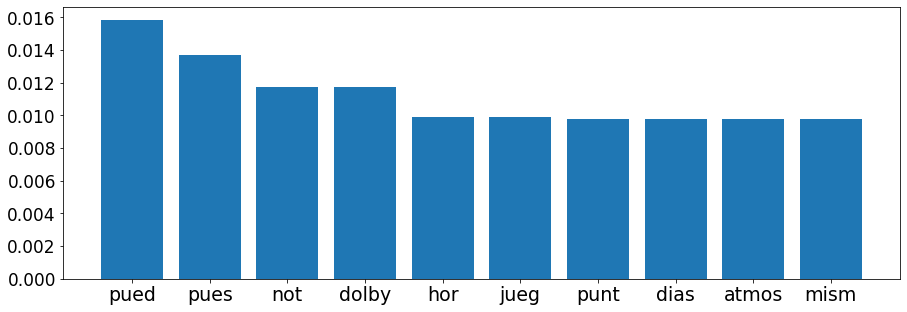

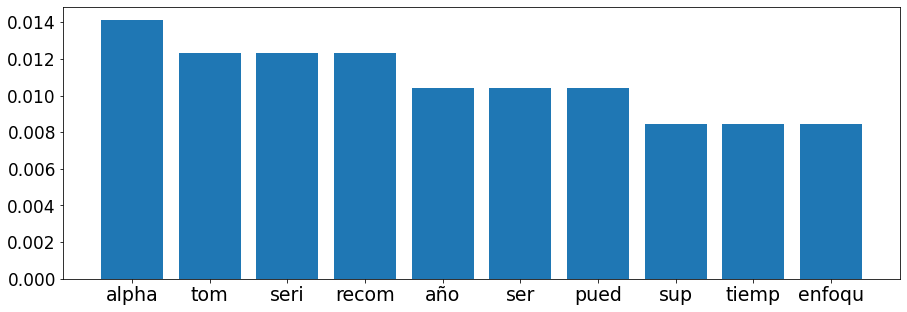

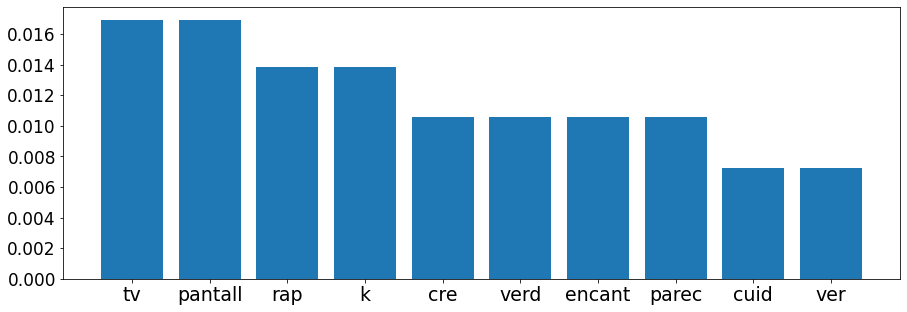

In [185]:
palabras_mas_probables(Ptheta_d1)
palabras_mas_probables(Ptheta_d2)
palabras_mas_probables(Ptheta_d3)

In [23]:
comentarios_sin_stopwords = procesar_comentarios(Tema1) # procesamiento quitando stopwords
comentarios_sin_stopwords = [p for c in comentarios_sin_stopwords[:N1] for p in c] # Hago un solo documento(comentario)
P = Counter(comentarios_sin_stopwords) # Cuento las frecuencias de cada palabra
for palabra in P:
  P[palabra] /= len(comentarios_sin_stopwords)

In [123]:
suma = 0.0
for w in Ptheta_d1:
  suma += theta_d*Ptheta_d1[w]

In [165]:
lambda_B1 = 0.000000001
LOG_P1 = defaultdict(lambda : 0.00, {palabra:0.00 for palabra in vocab1})

for i in range(20):
  for w in vocab1:
    LOG_P1[w] = frec1[w]*log(Ptheta_B1[w] + (1-lambda_B1*suma),10) 

In [166]:
lambda_B2 = 0.000000001
LOG_P2 = defaultdict(lambda : 0.00, {palabra:0.00 for palabra in vocab2})

for i in range(20):
  for w in vocab1:
    LOG_P2[w] = frec2[w]*log(Ptheta_B2[w] + (1-lambda_B2*suma),10)
    
lambda_B3 = 0.000000001
LOG_P3 = defaultdict(lambda : 0.00, {palabra:0.00 for palabra in vocab3})

for i in range(20):
  for w in vocab3:
    LOG_P3[w] = frec3[w]*log(Ptheta_B3[w] + (1-lambda_B3*suma),10)

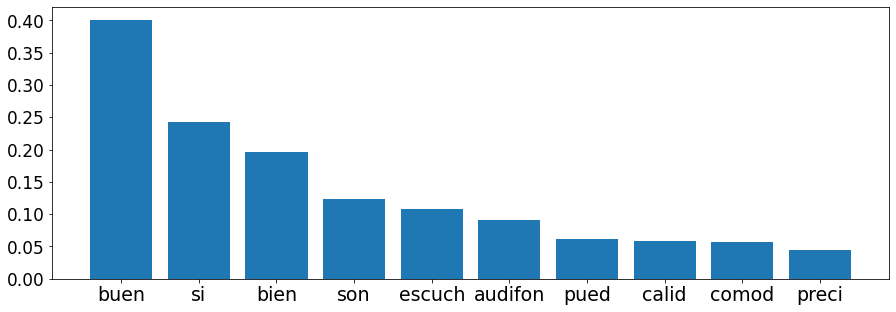

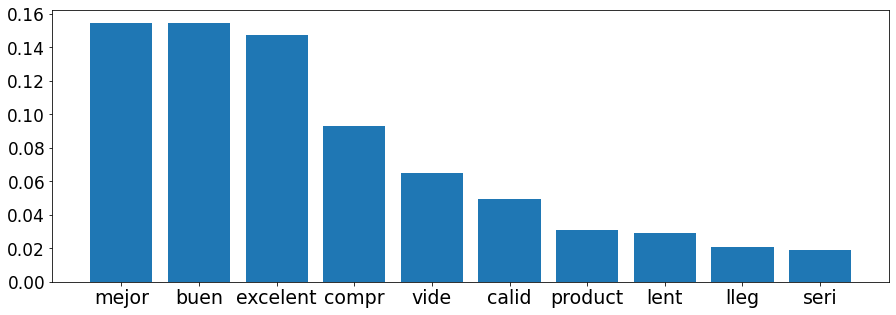

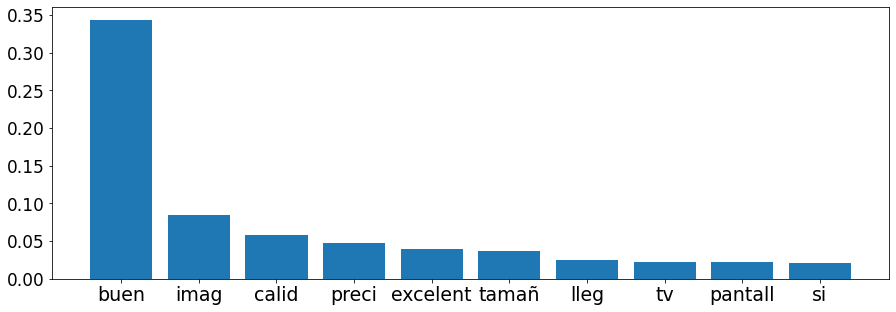

In [184]:
palabras_mas_probables(LOG_P1)
palabras_mas_probables(LOG_P2)
palabras_mas_probables(LOG_P3)